<a href="https://colab.research.google.com/github/ishan0810/Mental-health-detection-using-NLP/blob/main/mental_health_project_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Mental Health Signals in Social Media with NLP  


**Student:** Ishan Chotalia  



## 0. Setup & Imports



In [ ]:


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score,
)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

plt.rcParams['figure.figsize'] = (6, 4)


## 1. Load & Inspect Dataset

Use downloaded **`Combined Data.csv`** from the Kaggle dataset
“Sentiment Analysis for Mental Health” (Suchintika Sarkar).

Expected columns:
- `Unnamed: 0` – index-like column (we’ll drop it)
- `statement` – the text
- `status` – original label (`Normal`, `Depression`, `Suicidal`, `Anxiety`, `Bipolar`)

In [ ]:
DATA_PATH = "Combined Data.csv"  # adjust path if needed

df = pd.read_csv(DATA_PATH)
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nOriginal status value counts:")
print(df['status'].value_counts())


   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

Columns: ['Unnamed: 0', 'statement', 'status']

Original status value counts:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


## 2. Column Cleanup & Label Mapping

We will:

1. Drop `Unnamed: 0`  
2. Rename:
   - `statement` → `text`
   - `status` → `raw_status`
3. Map `raw_status` into three classes:
- Depressed  ← `Depression`, `Suicidal`, `Bipolar`
- Anxious    ← `Anxiety`
- Neutral    ← `Normal`

In [ ]:
# Drop index-like column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Rename columns
df = df.rename(columns={'statement': 'text', 'status': 'raw_status'})

# Map to 3-class labels
label_map = {
    'Normal': 'Neutral',
    'Depression': 'Depressed',
    'Suicidal': 'Depressed',
    'Bipolar': 'Depressed',
    'Anxiety': 'Anxious',
}

df['label'] = df['raw_status'].map(label_map)

print(df.head())
print("\nMapped label distribution:")
print(df['label'].value_counts())


                                                text raw_status    label
0                                         oh my gosh    Anxiety  Anxious
1  trouble sleeping, confused mind, restless hear...    Anxiety  Anxious
2  All wrong, back off dear, forward doubt. Stay ...    Anxiety  Anxious
3  I've shifted my focus to something else but I'...    Anxiety  Anxious
4  I'm restless and restless, it's been a month n...    Anxiety  Anxious

Mapped label distribution:
label
Depressed    28934
Neutral      16351
Anxious       3888
Name: count, dtype: int64


In [ ]:


import re

# 1) Define basic_clean if not already defined
def basic_clean(text: str) -> str:
    text = "" if pd.isna(text) else str(text)
    # strip common noise
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 2) Locate the text column (try common names)
if 'clean_text' not in df.columns:
    if 'text' in df.columns:
        source_col = 'text'
    elif 'statement' in df.columns:
        source_col = 'statement'
    elif 'body' in df.columns:
        source_col = 'body'
    else:
        raise KeyError("No text column found. Expected one of: 'clean_text','text','statement','body'.")

    # create/overwrite clean_text safely
    df['clean_text'] = df[source_col].apply(basic_clean)
    print(f"Created 'clean_text' from column: {source_col}")
else:
    print("'clean_text' already exists — leaving it as-is.")

# 3) Drop rows with unmapped labels (NaN in df['label']) if present
if 'label' not in df.columns:
    raise KeyError("No 'label' column found. Make sure you mapped raw_status -> label earlier.")
df = df[~df['label'].isna()].copy()

print("\nLabels after dropping NaN rows:")
print(df['label'].value_counts())
print("\n")

# 4) Display up to 3 example posts per label (safe even if class small)
for lab in sorted(df['label'].unique()):
    print("="*80)
    print(f"Examples for label: {lab}")

    subset = df.loc[df['label'] == lab]
    n_samples = min(3, len(subset))

    if n_samples == 0:
        print("No examples for this label.")
        continue

    sampled = subset.sample(n_samples, random_state=RANDOM_SEED)

    # use .loc to access values reliably
    for _, row in sampled.iterrows():
        print(f"- {row.loc['clean_text']}")


Created 'clean_text' from column: text

Labels after dropping NaN rows:
label
Depressed    28934
Neutral      16351
Anxious       3888
Name: count, dtype: int64


Examples for label: Anxious
- My anxiety is telling me not to be honest/vulnerable I have a second date (anxiety is also telling me it’s not a date and that I’m not of interest to anyone other than people that try to take advantage of me.) with someone next week. I am so excited because the first date was a /blast/. My anxiety is telling me to play it cool, and not to look too eager and to only express interest if they express interest first. I would have listened in the past. I think it would be in my best interest to tell them I’m looking forward to it because I am. So, I am going to tell them that I’m excited to see them next week. Better to be myself and turn-off someone that isn’t interested in my genuine excitement to spend time with them than it is to keep pretending.
- Worried I have ovarian cancer. The more I'm on so

## 3. Basic Cleaning & EDA

- Light text cleaning (URLs, usernames, whitespace)  
- Plot label distribution  
- Show example posts per class

Label distribution:
label
Depressed    28934
Neutral      16351
Anxious       3888
Name: count, dtype: int64


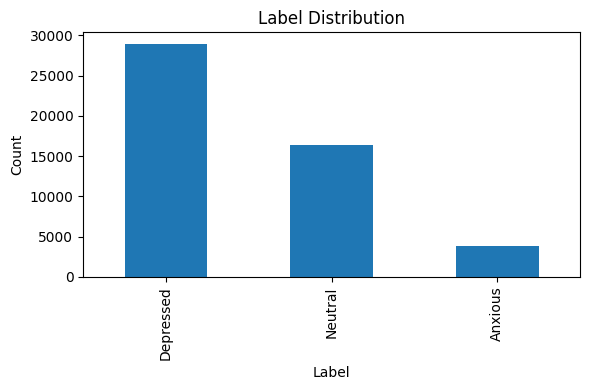

In [ ]:
import re

def basic_clean(text: str) -> str:
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['text'].apply(basic_clean)

print("Label distribution:")
print(df['label'].value_counts())

df['label'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
for lab in df['label'].unique():
    print("="*80)
    print(f"Examples for label: {lab}")
    subset = df[df['label'] == lab].sample(3, random_state=RANDOM_SEED)
    for _, row in subset.iterrows():
        print(f"- {row['clean_text']}")


Examples for label: Anxious
- My anxiety is telling me not to be honest/vulnerable I have a second date (anxiety is also telling me it’s not a date and that I’m not of interest to anyone other than people that try to take advantage of me.) with someone next week. I am so excited because the first date was a /blast/. My anxiety is telling me to play it cool, and not to look too eager and to only express interest if they express interest first. I would have listened in the past. I think it would be in my best interest to tell them I’m looking forward to it because I am. So, I am going to tell them that I’m excited to see them next week. Better to be myself and turn-off someone that isn’t interested in my genuine excitement to spend time with them than it is to keep pretending.
- Worried I have ovarian cancer. The more I'm on social media the more I hear about 'silent killer' cancers. I read that a common symptom of ovarian cancer is being bloated and feeling full quickly. I feel full a l

## 4. Sample Posts for Manual Annotation

Sample ~100 posts to annotate manually according to your own guidelines.

In [ ]:
SAMPLE_FOR_ANNOTATION = 100

sample_df = df.sample(min(SAMPLE_FOR_ANNOTATION, len(df)), random_state=RANDOM_SEED)
os.makedirs("data", exist_ok=True)
annotation_path = "data/to_annotate_sample.csv"
sample_df.to_csv(annotation_path, index=False)
print(f"Saved {len(sample_df)} posts for annotation to: {annotation_path}")
# After annotating, you can load it back as:
# annotated_df = pd.read_csv("data/annotated_sample.csv")


Saved 100 posts for annotation to: data/to_annotate_sample.csv


## 5. Train–Validation Split

Prepare data for baseline and transformer models.

In [ ]:
X = df['clean_text'].values
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

len(X_train), len(X_val)


(39338, 9835)

## 6. Baseline Model – Logistic Regression + TF–IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

log_reg = LogisticRegression(max_iter=1000, class_weight=None)
log_reg.fit(X_train_tfidf, y_train)

y_val_pred = log_reg.predict(X_val_tfidf)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

     Anxious       0.91      0.69      0.79       778
   Depressed       0.95      0.95      0.95      5787
     Neutral       0.91      0.95      0.93      3270

    accuracy                           0.93      9835
   macro avg       0.92      0.87      0.89      9835
weighted avg       0.93      0.93      0.93      9835



In [ ]:
labels = sorted(df['label'].unique())
cm = confusion_matrix(y_val, y_val_pred, labels=labels)
cm


array([[ 540,  168,   70],
       [  46, 5493,  248],
       [   9,  142, 3119]])

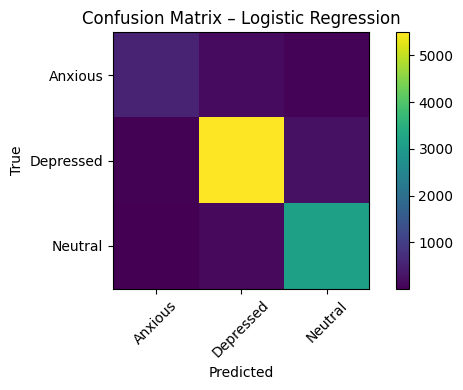

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix – Logistic Regression")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
plt.colorbar(im, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## 7. Basic Error Analysis

In [ ]:
mis_idx = np.where(y_val_pred != y_val)[0]
print(f"Number of misclassified examples: {len(mis_idx)}")

for idx in mis_idx[:8]:
    print("="*80)
    print("TEXT:")
    print(X_val[idx])
    print(f"TRUE LABEL: {y_val[idx]}")
    print(f"PRED LABEL: {y_val_pred[idx]}")


Number of misclassified examples: 683
TEXT:
#NAME?
TRUE LABEL: Depressed
PRED LABEL: Neutral
TEXT:
Canât believe I lost my damn car keys smh mind you the damn house key is on there ð this is the 2nd time my drunk aâ¦
TRUE LABEL: Depressed
PRED LABEL: Neutral
TEXT:
Now I am 28 and wasted too much opportunities. Wasted years not working on my dreams and creative ambitions...
TRUE LABEL: Depressed
PRED LABEL: Neutral
TEXT:
Hello everyone. I kindly ask you to fill up my survey about YOUR experience with DEPRESSION. It will help me with my research paper.Thank you! [** SURVEY
TRUE LABEL: Depressed
PRED LABEL: Neutral
TEXT:
i m a 0 year old male lb lately i ve been having a dull ache that come and go in my chest the right and the left side but never at the same time aching pain in my arm especially around the wrist and knuckle that come and go almost always at night an occasional dropping feeling in my chest like my heart dropping and nerve tingle or zap kind of like an small electric 

## 8. Transformer Model – DistilBERT

In [ ]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

import torch
from torch.utils.data import Dataset

label_list = sorted(df['label'].unique())
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

def encode_text(text):
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = [label2id[l] for l in labels]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = encode_text(self.texts[idx])
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# ---------------------------
# METRICS FUNCTION
# ---------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# ---------------------------
# TRAINING ARGUMENTS
# ---------------------------
training_args = TrainingArguments(
    output_dir="outputs/distilbert_mental_health",

    do_train=True,
    do_eval=True,

    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,

    learning_rate=2e-5,
    weight_decay=0.01,

    logging_steps=50,

    # REMOVED (these break on old versions):
    # evaluation_strategy
    # save_strategy
    # load_best_model_at_end
)

# ---------------------------
# TRAINER
# ---------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# ---------------------------
# TRAIN
# ---------------------------
# trainer.train()


## 9. Small Cross-Domain Dataset

Create `data/cross_domain_small.csv` with 20–30 posts from another source (same labels),
then evaluate both models on it.

In [ ]:
import pandas as pd

data = {
    "text": [
        "I can't focus on anything and feel extremely anxious.",
        "Life has been really hard lately and I'm feeling depressed.",
        "I feel okay today, not too bad.",
        "My chest is tight and I’m panicking for no reason.",
        "Nothing special happened, it's just a normal day."
    ],
    "label": ["Anxious", "Depressed", "Neutral", "Anxious", "Neutral"]
}

df_cross = pd.DataFrame(data)
df_cross.to_csv("data/cross_domain_small.csv", index=False)

print("Created data/cross_domain_small.csv with sample cross-domain texts.")


Created data/cross_domain_small.csv with sample cross-domain texts.


In [ ]:
try:
    cross_path = "data/cross_domain_small.csv"
    df_extra = pd.read_csv(cross_path)
    df_extra['clean_text'] = df_extra['text'].apply(basic_clean)

    X_extra = df_extra['clean_text'].values
    y_extra = df_extra['label'].values

    X_extra_tfidf = tfidf.transform(X_extra)
    y_extra_pred_lr = log_reg.predict(X_extra_tfidf)
    print("Logistic Regression on cross-domain data:")
    print(classification_report(y_extra, y_extra_pred_lr))

    # Transformer (if trained)
    # extra_dataset = TextDataset(X_extra, y_extra)
    # preds = trainer.predict(extra_dataset)
    # metrics_extra = compute_metrics((preds.predictions, preds.label_ids))
    # print("\nDistilBERT on cross-domain data:")
    # print(metrics_extra)
except FileNotFoundError:
    print("No 'data/cross_domain_small.csv' found yet.")


Logistic Regression on cross-domain data:
              precision    recall  f1-score   support

     Anxious       0.00      0.00      0.00         2
   Depressed       1.00      1.00      1.00         1
     Neutral       0.50      1.00      0.67         2

    accuracy                           0.60         5
   macro avg       0.50      0.67      0.56         5
weighted avg       0.40      0.60      0.47         5



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 10. Interpretability – Top Features

Use Logistic Regression coefficients to inspect top n-grams for each class.

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())
for lab in label_list:
    class_idx = list(log_reg.classes_).index(lab)
    class_coef = log_reg.coef_[class_idx]
    top_idx = np.argsort(class_coef)[-15:][::-1]

    print("="*80)
    print(f"Top positive features for class: {lab}")
    for i in top_idx:
        print(f"{feature_names[i]:<25} coef={class_coef[i]:.4f}")


Top positive features for class: Anxious
restless                  coef=8.5417
anxiety                   coef=8.3390
anxious                   coef=6.6021
worried                   coef=6.3549
nervous                   coef=5.7754
worry                     coef=4.3903
symptoms                  coef=3.3984
cancer                    coef=3.1830
health                    coef=3.1708
health anxiety            coef=3.1627
scared                    coef=2.9356
heart                     coef=2.6231
fear                      coef=2.4184
nan                       coef=2.3378
worrying                  coef=2.2610
Top positive features for class: Depressed
depression                coef=11.8237
am                        coef=6.8850
cannot                    coef=5.9027
bipolar                   coef=5.8886
suicide                   coef=5.5651
do not                    coef=5.4440
depressed                 coef=4.6176
myself                    coef=4.4679
manic                     coef=3.7296
sui

## 11. Small Model Improvement (A-Level)

Example: class-weighted Logistic Regression.

In [ ]:
log_reg_bal = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_bal.fit(X_train_tfidf, y_train)
y_val_pred_bal = log_reg_bal.predict(X_val_tfidf)
print("Class-weighted Logistic Regression:")
print(classification_report(y_val, y_val_pred_bal))


Class-weighted Logistic Regression:
              precision    recall  f1-score   support

     Anxious       0.75      0.89      0.82       778
   Depressed       0.97      0.91      0.94      5787
     Neutral       0.89      0.96      0.92      3270

    accuracy                           0.92      9835
   macro avg       0.87      0.92      0.89      9835
weighted avg       0.93      0.92      0.92      9835

